In [2]:
from __future__ import division

import os
import sys

In [49]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as scc
import scipy.integrate as scint
import scipy.interpolate as sctrp
import scipy.optimize as opt
import tqdm

from pycbc import waveform as wf

In [46]:
dark = False

if dark is True:
    mpl.rcParams.update(mpl.rc_params_from_file('matplotlibrc_dark'))
    darkstr = '_dark'
elif dark is False:
    mpl.rcParams.update(mpl.rc_params_from_file('matplotlibrc_light'))
    darkstr = ''
else:
    dark = False
mpl.rcParams.update({
                    'text.usetex': True,
                    })

cList = np.array([mpl.colors.hex2color(item['color']) for item in list(mpl.rcParams['axes.prop_cycle'])])
cListLight = np.array([mpl.colors.rgb_to_hsv(cc) for cc in cList])
cListLight[:,1] /= 2
cListLight = np.array([mpl.colors.hsv_to_rgb(cc) for cc in cListLight])

In [47]:
%matplotlib inline

In [48]:
r_earth = 6371e3 # m
hubble = 67.7 # km/(s Mpc)
W_m = 0.286 # 0.3089
W_lam = 1 - W_m
W_r = 0
mSun = 2e30

In [9]:
# Noise functions
f_ce_nu, strain_ce_nu = np.loadtxt('../data/ce_wb.dat').T
f_ce, strain_ce = np.loadtxt('../data/ce_wb_unfsr.dat').T
f_et, strain_et = np.loadtxt('../data/et_d.dat').T
f_voy, strain_voy = np.loadtxt('../data/voyager.dat').T
f_aligo, strain_aligo = np.loadtxt('../data/aligo.dat').T

def ce_noise(ff):
    return np.interp(ff, f_ce, strain_ce, left=1e-19, right=np.Inf)

def ce_noise_nu(ff):
    return np.interp(ff, f_ce_nu, strain_ce_nu, left=1e-19, right=np.Inf)

def et_noise(ff):
    return np.interp(ff, f_et[f_et>3], strain_et[f_et>3], left=np.Inf, right=np.Inf)

def voy_noise(ff):
    return np.interp(ff, f_voy, strain_voy, left=1e-19, right=np.Inf)

def aligo_noise(ff):
    return np.interp(ff, f_aligo, strain_aligo, left=1e-19, right=np.Inf)

det_noises = [aligo_noise, voy_noise, et_noise, ce_noise]
det_noises_nu = [aligo_noise, voy_noise, et_noise, ce_noise_nu]

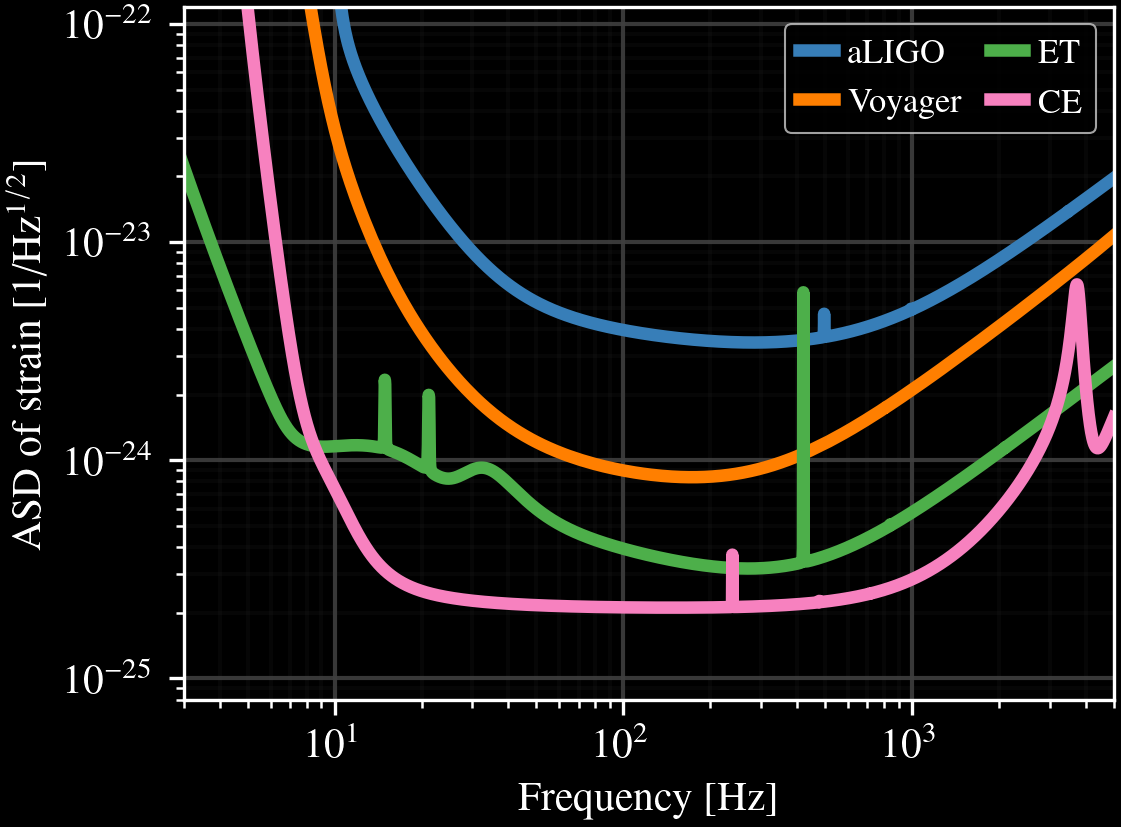

In [10]:
hnoise, axnoise = plt.subplots()
axnoise.loglog(f_aligo, strain_aligo, lw=3, label='aLIGO')
axnoise.loglog(f_voy, strain_voy, lw=3, label='Voyager')
axnoise.loglog(f_et, strain_et, lw=3, label='ET')
axnoise.loglog(f_ce_nu, strain_ce_nu, lw=3, label='CE')
#axnoise.loglog(f_ce_nu, strain_ce_nu, lw=3, label='CE')

axnoise.set_xlim([3, 5000])
axnoise.set_ylim([8e-26, 1.2e-22])
axnoise.set_xlabel('Frequency [Hz]')
axnoise.set_ylabel('ASD of strain [1/Hz$^{1/2}$]')
axnoise.grid('on', which='both')
axnoise.grid(which='minor', alpha=0.05*(1+dark))
axnoise.legend(loc='best', ncol=2)

In [31]:
def lum_dist(zz_arr):
    zz_arr = np.atleast_1d(zz_arr)
    DH = scc.c/1e3/hubble
    DD_arr = np.zeros(len(zz_arr))
    for ii, zz in enumerate(zz_arr):
        friedmann = lambda zzz: 1/np.sqrt(W_r * (1 + zzz)**4 + W_m * (1 + zzz)**3 + W_lam)
        myint = scint.quad(friedmann, 0, np.max([zz, 0]))
        DD_arr[ii] = DH * (1 + zz) * myint[0]
    try:
        DD_arr = DD_arr.item()
    except ValueError:
        pass
    return DD_arr

In [32]:
def get_waveform(m1=30, m2=30, phic=0, distance=1e3):
    fisco = scc.c**3/(scc.G*6**1.5*2*np.pi*(m1+m2)*mSun)
    df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
    mywf_p, mywf_c = wf.get_fd_waveform(
                        approximant='IMRPhenomD',
                        mass1=m1,
                        mass2=m2,
                        spin1z=0,
                        spin2z=0,
                        coa_phase=phic,
                        distance=distance,
                        delta_f = df,
                        f_lower = 0.5,
                        f_final = 0,
        )
    ff = np.array(mywf_p.sample_frequencies)
    mywfp = np.array(mywf_p.data)[ff>=1]
    #mywfc = np.array(mywf_c.data)[ff>=2]
    ff = ff[ff>=1]
    return ff, mywfp#, mywfc

In [33]:
def antennas(source_coords, det_coords, det_angles, freq=None):
    '''Return the plus and cross antenna patterns for GW sources incident on a detector network.
    Frequency dependence is not currently implemented.
    
    Arguments:
        source_coords (array): array of coordinates for GWs, each specified as [theta, phi, psi],
            where theta is the colatitude, phi is the longitude, and psi is the polarization angle
        det_coords (array): array of coordinates for detectors, each specified as [theta, phi]
        det_angles (array): array of angles describing detector arms, each specified as [rho, alpha],
            where rho is the angle of the X-arm wrt due east, and alpha is the detector opening angle
        return_times (boolean): if True, return the source times relative to geocenter. Defaults to True.
        
    Returns:
        det_plus (array): plus antenna pattern
        det_cross (array): cross antenna pattern
        source_times (array): source times relative to geocenter, in seconds.
    
    '''
    
    source_theta, source_phi, source_psi, _ = source_coords.T
    
    # Construct GW direction vectors
    source_n = np.array([
            np.sin(source_theta)*np.cos(source_phi),
            np.sin(source_theta)*np.sin(source_phi),
            np.cos(source_theta),
        ]).T
    source_ex = np.array([
            np.sin(source_phi) * np.cos(source_psi) - np.cos(source_theta) * np.cos(source_phi) * np.sin(source_psi),
            -np.cos(source_phi) * np.cos(source_psi) - np.cos(source_theta) * np.sin(source_phi) * np.sin(source_psi),
            np.sin(source_theta) * np.sin(source_psi),
        ]).T
    source_ey = np.array([
            -np.sin(source_phi) * np.sin(source_psi) - np.cos(source_theta) * np.cos(source_phi) * np.cos(source_psi),
            np.cos(source_phi) * np.sin(source_psi) - np.cos(source_theta) * np.sin(source_phi) * np.cos(source_psi),
            np.sin(source_theta) * np.cos(source_psi),
        ]).T
    
    # Construct detector direction vectors
    det_theta, det_phi = det_coords.T
    det_rho, det_alpha = det_angles.T
    
    det_n = np.array([
            np.sin(det_theta)*np.cos(det_phi),
            np.sin(det_theta)*np.sin(det_phi),
            np.cos(det_theta),
        ]).T
    det_ex = np.array([
            np.sin(det_phi) * np.cos(-det_rho) - np.cos(det_theta) * np.cos(det_phi) * np.sin(-det_rho),
            -np.cos(det_phi) * np.cos(-det_rho) - np.cos(det_theta) * np.sin(det_phi) * np.sin(-det_rho),
            np.sin(det_theta) * np.sin(-det_rho),
        ]).T
    det_ey = np.array([
            np.sin(det_phi) * np.cos(-det_rho-det_alpha) - np.cos(det_theta) * np.cos(det_phi) * np.sin(-det_rho-det_alpha),
            -np.cos(det_phi) * np.cos(-det_rho-det_alpha) - np.cos(det_theta) * np.sin(det_phi) * np.sin(-det_rho-det_alpha),
            np.sin(det_theta) * np.sin(-det_rho-det_alpha),
        ]).T
    
    # Construct source tensors
    source_plus = np.einsum('...a,...b', source_ex, source_ex) - np.einsum('...a,...b', source_ey, source_ey)
    source_cross = np.einsum('...a,...b', source_ex, source_ey) + np.einsum('...a,...b', source_ey, source_ex)

    # Construct detector freq resp
    if freq is None:
        Dx = 0.5*np.ones((source_n.shape[0], det_ex.shape[0]))
        Dy = 0.5*np.ones((source_n.shape[0], det_ex.shape[0]))
    else:
        LL = det_dict['det_lengths'][0]
        nx = np.einsum('ab,cb -> ac', source_n, det_ex)
        ny = np.einsum('ab,cb -> ac', source_n, det_ey)
        Dx = (scc.c / (8j * np.pi * freq * LL)
              * ((1 - np.exp(-2j*np.pi*freq*(1-nx)*LL/scc.c)) / (1 - nx)
              - np.exp(-4j*np.pi*freq*LL/scc.c) * (1 - np.exp(2j*np.pi*freq*(1+nx)*LL/scc.c)) / (1 + nx)))
        Dy = (scc.c / (8j * np.pi * freq * LL)
              * ((1 - np.exp(-2j*np.pi*freq*(1-ny)*LL/scc.c)) / (1 - ny)
              - np.exp(-4j*np.pi*freq*LL/scc.c) * (1 - np.exp(2j*np.pi*freq*(1+ny)*LL/scc.c)) / (1 + ny)))
    
    #Dx2 = np.einsum('a,bc,bd -> abcd', Dx, det_ex, det_ex)
    #Dy2 = np.einsum('a,bc,bd -> abcd', Dy, det_ey, det_ey)
    
    Dx2 = np.einsum('ab,bc,bd->abcd', Dx, det_ex, det_ex)
    Dy2 = np.einsum('ab,bc,bd->abcd', Dy, det_ey, det_ey)

    #Construct detector tensor
    #det_tensor = 0.5 * (np.einsum('...a,...b', det_ex, det_ex) * Dx - np.einsum('...a,...b', det_ey, det_ey)) * Dy
    det_tensor = Dx2 - Dy2
    
    # Construct detector antenna responses
    det_plus = np.einsum('abc, adbc -> ad', source_plus, det_tensor)
    det_cross = np.einsum('abc, adbc -> ad', source_cross, det_tensor)
    
    det_plus = np.einsum('abc, adbc -> ad', source_plus, det_tensor)
    det_cross = np.einsum('abc, adbc -> ad', source_cross, det_tensor)
    
    return det_plus, det_cross

In [34]:
# Build detector dictionaries
aligo_dict = {'det_coords': np.array([[0, 0]]),
              'det_angles': np.array([[0, np.pi/2]]),
              'det_noises': [aligo_noise],
              'det_lengths': np.array([4e3]),
              'label': 'aLIGO',
             }

voy_dict = {'det_coords': np.array([[0, 0]]),
            'det_angles': np.array([[0, np.pi/2]]),
            'det_noises': [voy_noise],
            'det_lengths': np.array([4e3]),
            'label': 'Voyager',
             }

et_dict = {'det_coords': np.array([
                [0, 0],
                [0, 0],
                [0, 0],
            ]),
           'det_angles': np.array([
                [0, np.pi/3],
                [np.pi/3, np.pi/3],
                [2*np.pi/3, np.pi/3],
            ]),
           'det_noises': 3*[et_noise],
           'det_lengths': np.array(3*[10e3]),
           'label': 'ET',
          }

ce_dict = {'det_coords': np.array([[0, 0]]),
           'det_angles': np.array([[0, np.pi/2]]),
           'det_noises': [ce_noise],
           'det_lengths': np.array([40e3]),
           'label': 'CE',
           }

ce_nu_dict = {'det_coords': np.array([[0, 0]]),
           'det_angles': np.array([[0, np.pi/2]]),
           'det_noises': [ce_noise_nu],
           'det_lengths': np.array([40e3]),
           'label': 'CE',
           }

det_dict_list = [aligo_dict, voy_dict, et_dict, ce_dict]

det_dict_list_nu = [aligo_dict, voy_dict, et_dict, ce_nu_dict]

In [35]:
# Generate sources
num_source = int(1e3)
theta_rand = np.arccos(np.random.uniform(low=-1, high=1, size=num_source))
phi_rand = np.random.uniform(low=0, high=2*np.pi, size=num_source)
psi_rand = np.random.uniform(low=0, high=2*np.pi, size=num_source)
iota_rand = np.arccos(np.random.uniform(low=-1, high=1, size=num_source))

source_coords = np.vstack([
        theta_rand,
        phi_rand,
        psi_rand,
        iota_rand,
    ]).T

In [36]:
h0 = 1e-24

def snr_simple(ff, det_noises, source_extinctions):
    det_noises_sq_arr = np.array([np.square(det_noises[kk](ff)) for kk in range(len(det_noises))])
    weights = np.einsum('ba,ac->bc', h0**2 * source_extinctions, np.reciprocal(det_noises_sq_arr))
    return weights

# We'll need this function to find the horizon redshifts

def snrfunc(zz, zz0, ff0, waveform0, source_extinctions, det_noises):
    lum_dist0 = lum_dist(zz0)
    ff = ff0/(1+zz)
    det_noises_sq_arr = np.array([np.square(det_noises[kk](ff)) for kk in range(len(det_noises))])
    #weights = np.sum(1/det_noises_arr**2, axis=0)
    weights = np.einsum('a,ab', source_extinctions, np.reciprocal(det_noises_sq_arr))
    intgnd = waveform0*lum_dist0/lum_dist(zz)*(1+zz)**2
    snrsq = 4 * np.trapz(weights*(np.square(np.real(intgnd))+np.square(np.imag(intgnd))), ff)
    return np.sqrt(np.max([snrsq, 0]))
    #return np.sqrt(np.max(4 * np.trapz(weights*np.abs(waveform0*lum_dist0/lum_dist(zz)*(1+zz)**2)**2, ff), 0))

def minfunc(zz, zz0, ff0, waveform0, source_extinctions, det_noises):
    lum_dist0 = lum_dist(zz0)
    ff = ff0/(1+zz)
    det_noises_sq_arr = np.array([np.square(det_noises[kk](ff)) for kk in range(len(det_noises))])
    weights = np.einsum('a,ab', source_extinctions, np.reciprocal(det_noises_sq_arr))
    intgnd = waveform0*lum_dist0/(1e-3+lum_dist(zz))*(1+zz)**2
    snrsq = 4 * np.trapz(weights*(np.square(np.real(intgnd))+np.square(np.imag(intgnd))), ff)
    return np.square(np.max([snrsq, 0]) - 64)

In [37]:
zz0 = 0.001
mTot_range = np.logspace(0, 4, 120)
zz_range = np.logspace(-2, 2, 120)
f_full = np.logspace(np.log10(3), np.log10(5e3), 300)

In [38]:
for det_dict in det_dict_list_nu:
    
    det_coords = det_dict['det_coords']
    det_angles = det_dict['det_angles']
    
    aa = (1+np.cos(iota_rand)**2) / 2
    bb = 1j * np.cos(iota_rand)
    hplus = aa * np.cos(2*psi_rand) + bb * np.sin(2*psi_rand)
    hcross = aa * np.sin(2*psi_rand) - bb * np.cos(2*psi_rand)
    
    det_dict['det_plus'], det_dict['det_cross'] = antennas(source_coords, det_coords, det_angles)
    det_dict['source_extinctions'] = (np.einsum('...a, ...', det_dict['det_plus']**2, np.abs(aa)**2)#np.abs(np.square(hplus)))
                              + np.einsum('...a, ...', det_dict['det_cross']**2, np.abs(bb)**2))#np.abs(np.square(hcross))))
    det_dict['extinction_percentiles'] = np.array([np.percentile(det_dict['source_extinctions'], ii, axis=0)
                                                   for ii in [50, 90, 100]])
    
    det_dict['horizon_redshifts'] = np.zeros((len(mTot_range), len(det_dict['extinction_percentiles'])))
    
    det_dict['det_plus_opt'], det_dict['det_cross_opt'] = antennas(np.array([[0, 0, 0, 0]]), det_coords, det_angles)
    det_dict['extinction_opt'] = det_dict['det_plus_opt']**2 + det_dict['det_cross_opt']**2
    det_dict['opt_snrs'] = np.zeros((len(mTot_range), len(zz_range)))
    
    det_dict['snr_simple'] = snr_simple(f_full, det_dict['det_noises'], det_dict['source_extinctions'])

In [39]:
with tqdm.tqdm(range(len(mTot_range)*len(det_dict_list))) as pbar:
    for ii, mTot in enumerate(mTot_range):
        ff, mywf = get_waveform(m1=mTot/2, m2=mTot/2, distance=lum_dist(zz0))
        for det_dict in det_dict_list_nu:
            for jj, extinction_percentiles in enumerate(det_dict['extinction_percentiles']):
                zzinit = 0.01#+0.5*mTot/mTot_range[-1] # initial guess
                qq = opt.leastsq(minfunc, zzinit, args=(zz0, ff, mywf, extinction_percentiles, det_dict['det_noises']),
                                ftol=1e-4, xtol=1e-4)
                det_dict['horizon_redshifts'][ii, jj] = qq[0][0]
            zz1, zz2 = 1, 10
            for jj, zz in enumerate(zz_range):
                det_dict['opt_snrs'][ii, jj] = np.squeeze(snrfunc(zz, zz0, ff, mywf,
                                                                  det_dict['extinction_opt'][0], det_dict['det_noises']))
                #det_dict['opt_snrs'][ii, 1] = snrfunc(zz2, zz0, ff, mywf, det_dict['det_noises'])
            pbar.update()

  0%|          | 0/480 [00:00<?, ?it/s]

100%|██████████| 480/480 [00:57<00:00,  8.41it/s]


In [40]:
zz1_ind = np.abs(zz_range - 1).argmin()
zz10_ind = np.abs(zz_range - 10).argmin()

# Horizon plot and optimal SNR versus total mass

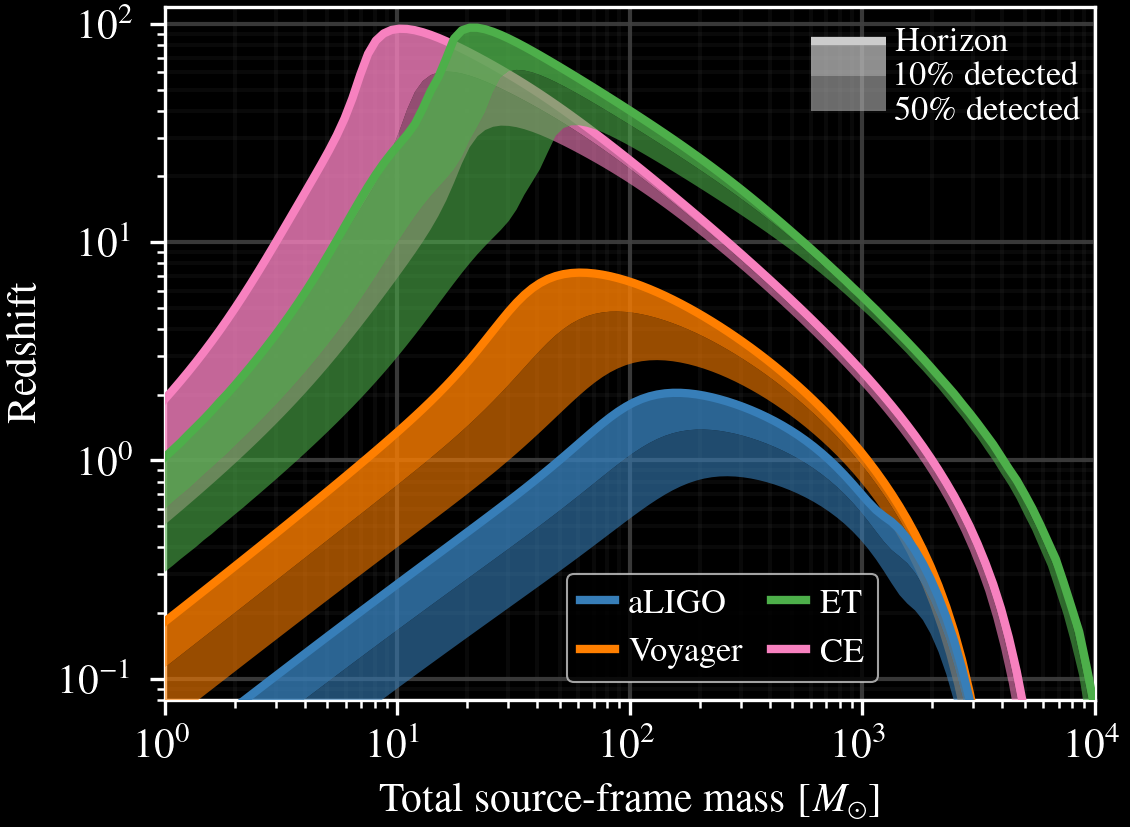

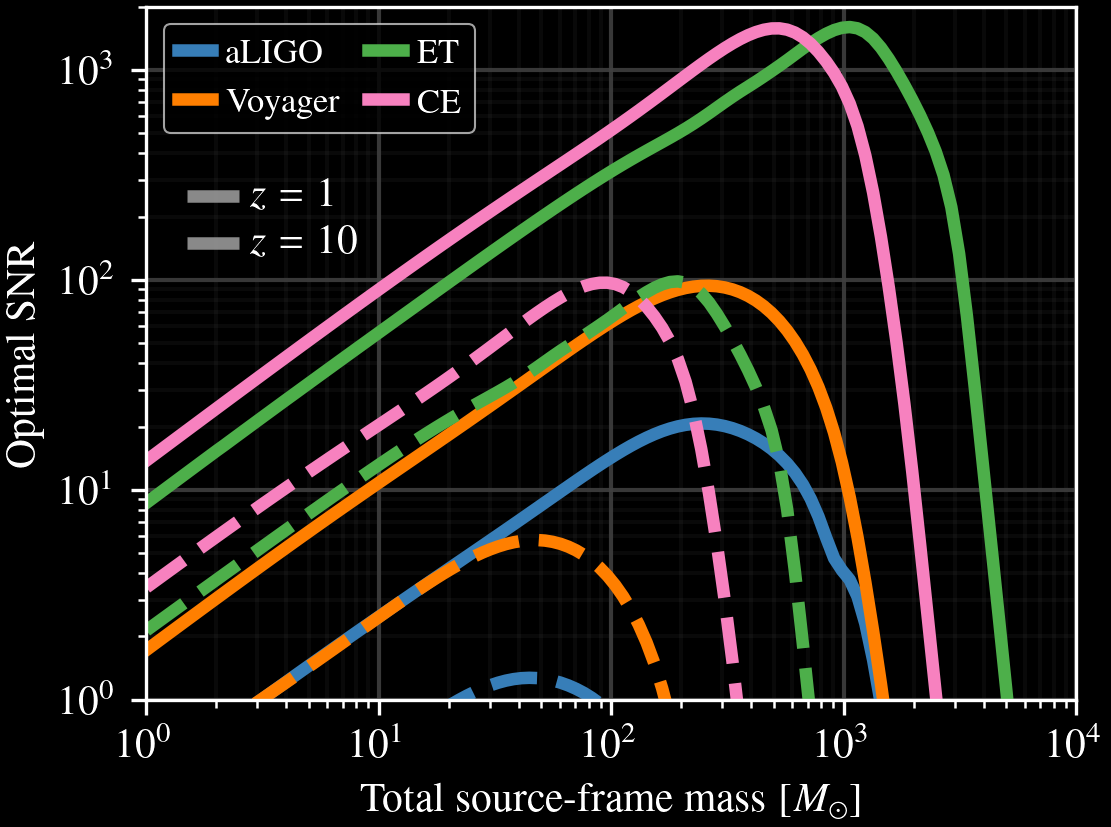

In [41]:
hhor, axhor = plt.subplots()
hhor.set_size_inches(4,3)
hsnr, axsnr = plt.subplots()

for ii, det_dict in enumerate(det_dict_list_nu):
    axhor.loglog(mTot_range, det_dict['horizon_redshifts'][:,2], label=det_dict['label'], color=cList[ii],
                 zorder=100-3*ii, alpha=1.0)
    axhor.fill_between(mTot_range, det_dict['horizon_redshifts'][:,1], det_dict['horizon_redshifts'][:,2],
                      zorder=100-3*ii-1, facecolor=cList[ii], lw=0, alpha=0.6+0.2*dark)
    axhor.fill_between(mTot_range, det_dict['horizon_redshifts'][:,0], det_dict['horizon_redshifts'][:,1],
                      zorder=100-3*ii-2, facecolor=cList[ii]*dark+cListLight[ii]*(1-dark), lw=0, alpha=0.6)
    
    axsnr.loglog(mTot_range, det_dict['opt_snrs'][:,zz1_ind], lw=3, label=det_dict['label'], c=cList[ii])
    axsnr.loglog(mTot_range, det_dict['opt_snrs'][:,zz10_ind], '--', lw=3, c=cList[ii])
    
x0 = np.array([0.695, 0.775])
x1 = 0.785
y1 = 0.95
y2 = 0.90
y3 = 0.85
axhor.loglog(x0, 0*x0+y1, color=(0.3+0.5*dark, 0.3+0.5*dark, 0.3+0.5*dark, 1.0), solid_capstyle='butt', transform=axhor.transAxes)
axhor.fill_between(x0, 0*x0+y2, 0*x0+y1, facecolor=(0.5+0.2*dark, 0.5+0.2*dark, 0.5+0.2*dark, 0.6+0.2*dark), lw=0, transform=axhor.transAxes)
axhor.fill_between(x0, 0*x0+y3, 0*x0+y2, facecolor=(0.7, 0.7, 0.7, 0.6), lw=0, transform=axhor.transAxes)
axhor.text(x1, y1, 'Horizon', va='center', fontsize='small', transform=axhor.transAxes)
axhor.text(x1, y2, '10\% detected', va='center', fontsize='small', transform=axhor.transAxes)
axhor.text(x1, y3, '50\% detected', va='center', fontsize='small', transform=axhor.transAxes)

axhor.set_xscale('log')
axhor.set_yscale('log')
axhor.set_xlim([mTot_range[0], mTot_range[-1]])
axhor.set_ylim([0.08, 120])
axhor.set_xlabel('Total source-frame mass [$M_\odot$]')
axhor.set_ylabel('Redshift')
axhor.legend(loc='lower left', bbox_transform=axhor.transData, bbox_to_anchor=(45,0.08), ncol=2).set_zorder(101)
axhor.grid('on', which='both')
axhor.grid(which='minor', alpha=0.05*(1+2*dark))

#axsnr.set_xlim([1, 500])
axsnr.set_xlim([mTot_range[0], mTot_range[-1]])
axsnr.set_ylim([1, 2e3])
axsnr.set_xlabel('Total source-frame mass [$M_\odot$]')
axsnr.set_ylabel('Optimal SNR')
axsnr.legend(loc='upper left', ncol=2)
x0 = np.array([1.5, 2.5])
y1 = 250
y2 = 150
axsnr.loglog(x0, 0*x0+y1, lw=3, c=(0.3*(1+dark), 0.3*(1+dark), 0.3*(1+dark), 0.9), solid_capstyle='butt')
axsnr.loglog(x0, 0*x0+y2, '--', lw=3, c=(0.3*(1+dark), 0.3*(1+dark), 0.3*(1+dark), 0.9), dashes=(7, 3), solid_capstyle='butt')
axsnr.text(1.1*x0[1], y1, r'$z = 1$', va='center')
axsnr.text(1.1*x0[1], y2, r'$z = 10$', va='center')
axsnr.grid('on', which='both')
axsnr.grid(which='minor', alpha=0.05*(1+2*dark))

# Waterfall plots

In [42]:
#ll = [3, 10, 30, 100, 300, 1000]
ll = [10, 20, 50, 100, 200, 500]

In [43]:
if dark is True:
    cc = mpl.cm.viridis(np.linspace(30, 226, len(ll)).astype(int))**0.75
else:
    cc = mpl.cm.viridis(np.linspace(30, 226, len(ll)).astype(int))**(4/3)

In [44]:
def draw_labels(ax, cs, **clabel_dict):
    # get limits if they're automatic
    xmin,xmax,ymin,ymax = ax.axis()
    # work with logarithms for loglog scale
    # middle of the figure:
    xscale = ax.get_xscale()
    yscale = ax.get_yscale()
 #   if xscale is 'log':
 #       logmidx = (xmin+xmax)/2
 #   else:
 #       logmidx = 
    logmid = (np.log10(xmin)+np.log10(xmax))/2, (ymin+ymax)/2#(np.log10(ymin)+np.log10(ymax))/2
    label_pos = []
    for line in cs.collections:
        for path in line.get_paths():
            thevertices = path.vertices
            themask = np.all([
                            thevertices[:,0]>1.03*xmin,
                            thevertices[:,0]<0.97*xmax,
                            thevertices[:,1]>1.03*ymin,
                            thevertices[:,1]<0.97*ymax,
                             ], axis=0)
            logvert = np.log10(thevertices[themask])
            if np.size(logvert) == 0:
                logvert = np.log10(thevertices)

            # find closest point
            logdist = np.linalg.norm(logvert-logmid, ord=2, axis=1)
            min_ind = np.argmin(logdist)
            label_pos.append(10**logvert[min_ind,:])

    # draw labels, hope for the best
    clab = ax.clabel(cs, manual=label_pos, **clabel_dict)
    return clab

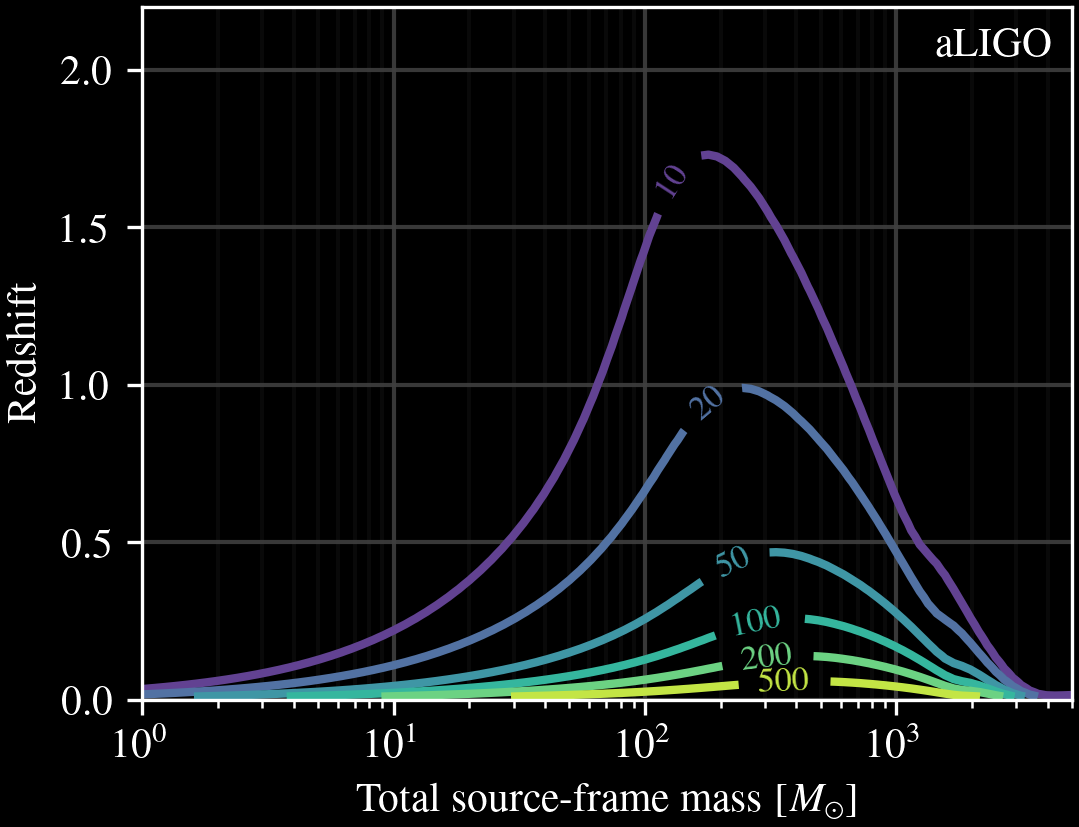

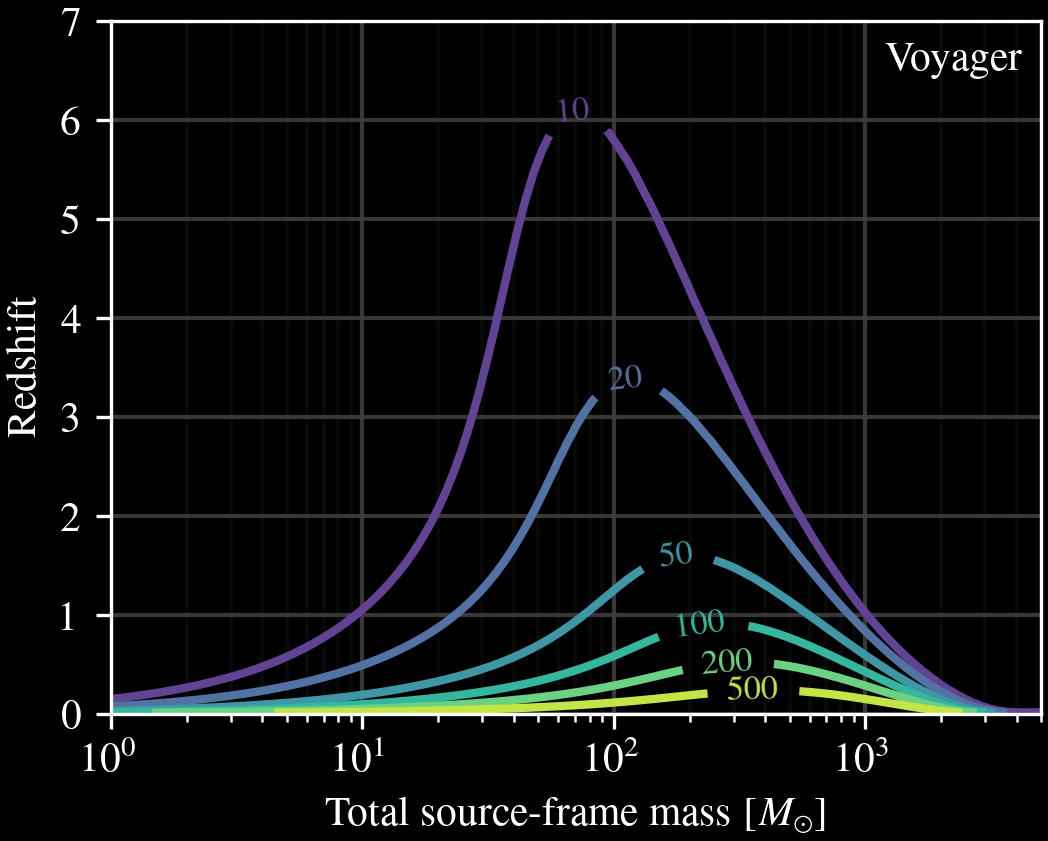

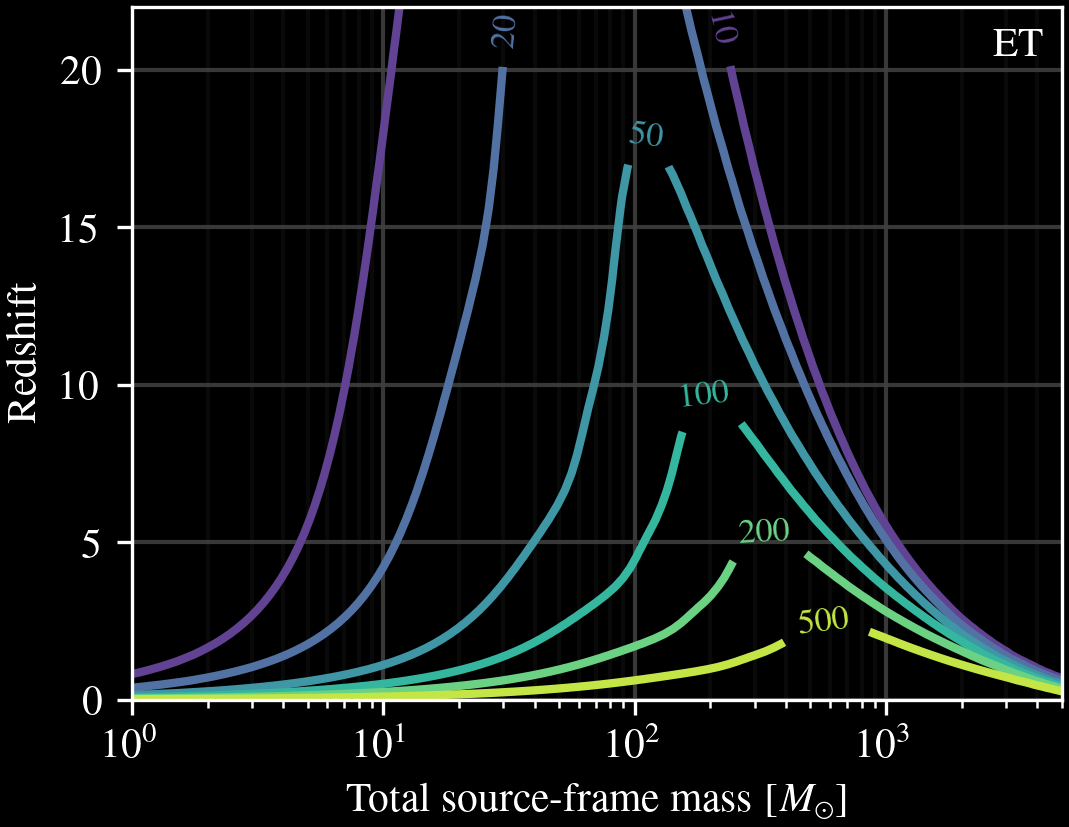

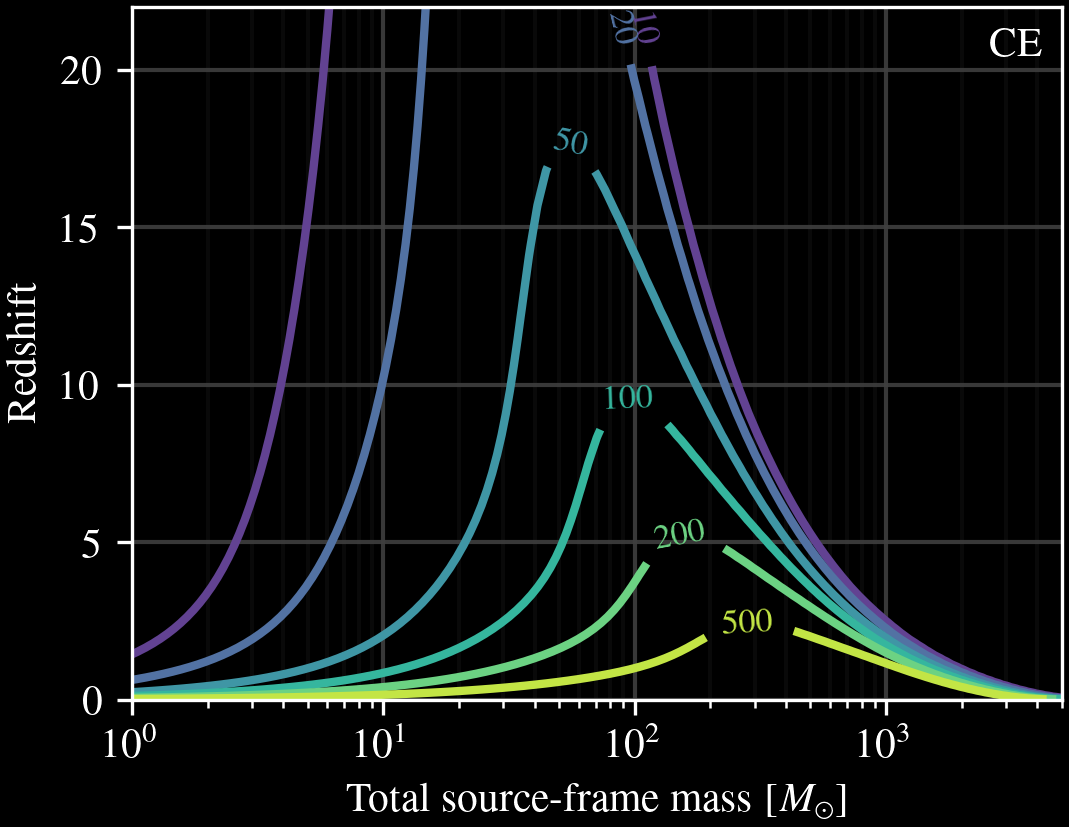

In [45]:
#h_wf_alig, ax_wf_ce = plt.subplots()
#h_wf_ce, ax_wf_ce = plt.subplots()
#h_wf_ce, ax_wf_ce = plt.subplots()
#h_wf_ce, ax_wf_ce = plt.subplots()
ymax_list = [2.2, 7, 22, 22]
h_wf_list = []
ax_wf_list = []
for ii, det_dict in enumerate(det_dict_list_nu):
    hh, ax = plt.subplots()
    cs = ax.contour(mTot_range, zz_range, det_dict['opt_snrs'].T, levels=ll, colors=cc)
    ax.set_xscale('log')
    ax.set_xlim(1, 5e3)
    ax.set_ylim(0, ymax_list[ii])
    ax.text(0.98, 0.97, det_dict['label'], ha='right', va='top', transform=ax.transAxes)
    #ax.set_yscale('symlog')
    draw_labels(ax, cs, fmt='%.0f', fontsize='small', inline_spacing=20)
    ax.set_xlabel('Total source-frame mass [$M_\odot$]')
    ax.set_ylabel('Redshift')
    ax.grid(True, which='both')
    ax.grid(which='minor', alpha=0.05*(1+2*dark))
    #ax.set_xlim(mTot_range[0], mTot_range[-1])
    h_wf_list.append(hh)
    ax_wf_list.append(ax)

# Optimal SNR versus redshift

In [98]:
zz_range_2 = np.logspace(-1, 2, 300)
ff_ns, mywf_ns = get_waveform(m1=1.5, m2=1.5, distance=lum_dist(zz0))
ff_bh, mywf_bh = get_waveform(m1=30, m2=30, distance=lum_dist(zz0))
opt_snrs_ns = np.zeros((len(det_noises), len(zz_range_2)))
opt_snrs_bh = np.zeros((len(det_noises), len(zz_range_2)))
for ii, det_dict in enumerate(det_dict_list_nu):
    for jj, zz in enumerate(zz_range_2):
        opt_snrs_ns[ii,jj] = snrfunc(zz, zz0, ff_ns, mywf_ns, det_dict['extinction_opt'][0], det_dict['det_noises'])
        opt_snrs_bh[ii,jj] = snrfunc(zz, zz0, ff_bh, mywf_bh, det_dict['extinction_opt'][0], det_dict['det_noises'])

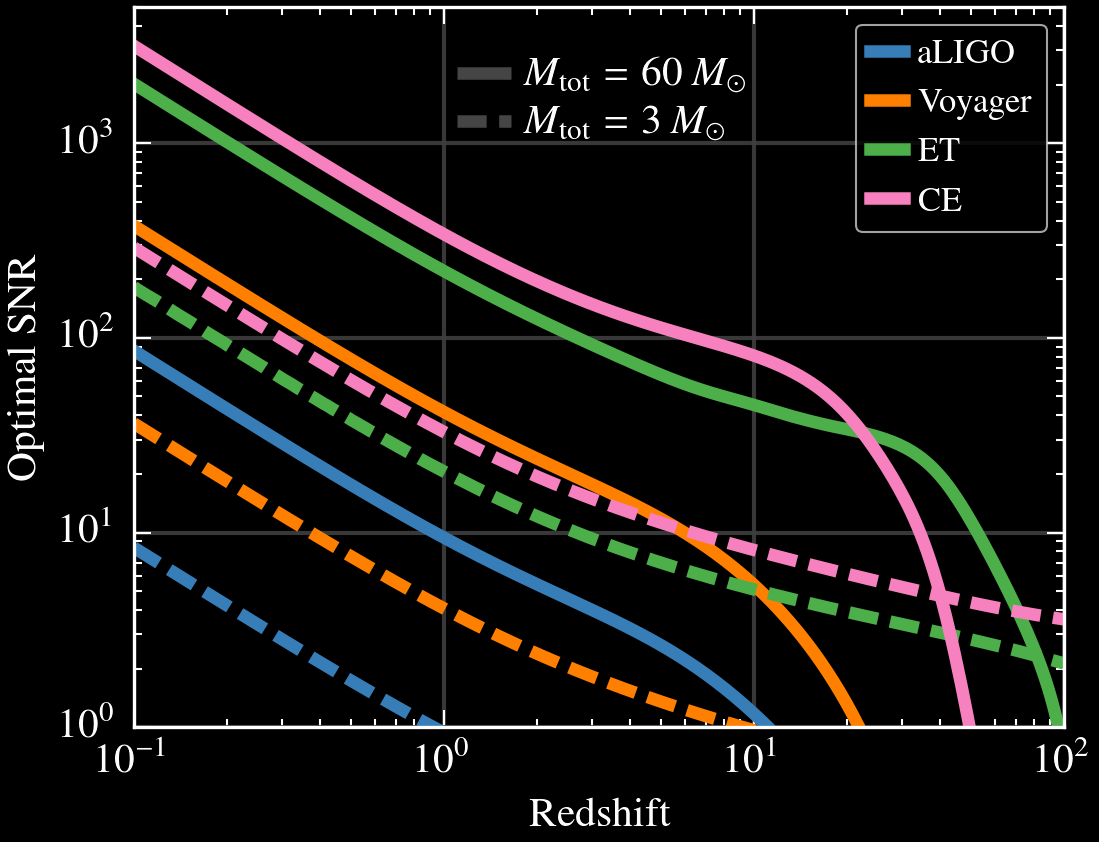

In [240]:
hsnrzz, axsnrzz = plt.subplots()
for ii, det_dict in enumerate(det_dict_list):
    axsnrzz.loglog(zz_range_2, opt_snrs_bh[ii], lw=3, c=cList[ii], label=det_dict['label'])
    axsnrzz.loglog(zz_range_2, opt_snrs_ns[ii], '--', lw=3, c=cList[ii], dashes=(7, 3))
axsnrzz.set_ylim([1, 5e3])
axsnrzz.set_xlabel('Redshift')
axsnrzz.set_ylabel('Optimal SNR')
x0 = np.array([1.1, 1.65])
y1 = 2300
y2 = 1300
axsnrzz.loglog(x0, 0*x0+y1, lw=3, c=(0.3, 0.3, 0.3, 0.9), solid_capstyle='butt')
axsnrzz.loglog(x0, 0*x0+y2, '--', lw=3, c=(0.3, 0.3, 0.3, 0.9), dashes=(7, 3), solid_capstyle='butt')
axsnrzz.text(1.8, 0.9*y1, r'$M_\mathrm{tot} = 60\,M_\odot$', va='center')
axsnrzz.text(1.8, 0.9*y2, r'$M_\mathrm{tot} = 3\,M_\odot$', va='center')
axsnrzz.legend()

# Effective strain curves

$$\begin{align}
    h_+ &= \tfrac{1}{2}(1 + \cos^2{\iota})\cos2\psi + \mathrm{i} \cos\iota\,\sin2\psi \\
    h_\times &= \tfrac{1}{2}(1 + \cos^2{\iota})\sin2\psi - \mathrm{i} \cos\iota\,\cos2\psi \\
    \end{align}$$

In [100]:
Nf = 1000
freqs = np.logspace(np.log10(1), np.log10(5e3), Nf)

In [101]:
hplus = (1+np.cos(iota_rand)**2)/2 * np.cos(2*psi_rand) + 1j * np.cos(iota_rand) * np.sin(2*psi_rand)
hcross = (1+np.cos(iota_rand)**2)/2 * np.sin(2*psi_rand) - 1j * np.cos(iota_rand) * np.cos(2*psi_rand)

In [102]:
strains_list = []
for det_dict in [aligo_dict, voy_dict, et_dict, ce_dict]:
    det_plus, det_cross = antennas(source_coords, det_dict['det_coords'], det_dict['det_angles'], 10)
    dpf = np.zeros((num_source, len(det_dict['det_noises']), Nf), dtype=np.complex)
    dcf = np.zeros((num_source, len(det_dict['det_noises']), Nf), dtype=np.complex)
    for ii in tqdm.tqdm(range(Nf)):
        dpf[:,:,ii], dcf[:,:,ii] = antennas(source_coords, det_dict['det_coords'], det_dict['det_angles'], freqs[ii])
    numerators = np.abs(np.einsum('a,abc->abc', hplus, dpf) + np.einsum('a,abc->abc', hcross, dcf))**2
    denominators = np.array([1/noise(freqs)**2 for noise in det_dict['det_noises']])
    strains = np.sqrt(1/np.einsum('abc,bc->ac', numerators, denominators))
    strains_list.append(strains)

100%|██████████| 1000/1000 [00:03<00:00, 279.98it/s]
/cvmfs/oasis.opensciencegrid.org/ligo/deploy/sw/pycbc/x86_64_rhel_7/virtualenv/pycbc-v1.11.8/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 1000/1000 [00:01<00:00, 535.46it/s]


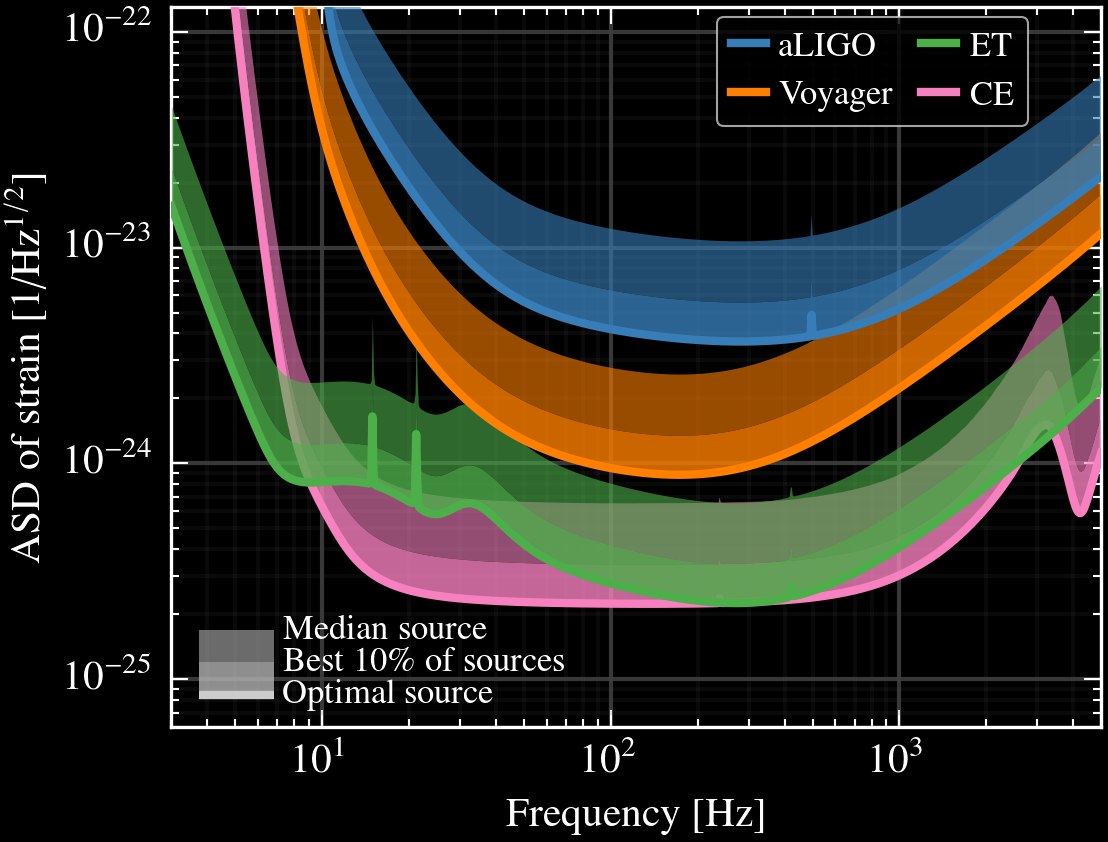

In [241]:
horizon_noise_list = []
better_noise_list = []
med_noise_list = []
h_noise_pct, ax_noise_pct = plt.subplots()
for ii, det_dict in enumerate([aligo_dict, voy_dict, et_dict, ce_dict]):
    horizon_noise = np.min(strains_list[ii], axis=0)
    better_noise = np.percentile(strains_list[ii], 10, axis=0)
    med_noise = np.median(strains_list[ii], axis=0)
    np.savetxt('../results/{}_noise_pct.txt'.format(det_dict['label']),
               np.vstack([freqs, horizon_noise, better_noise, med_noise]).T,
               header='f [Hz]   Optimal    10%        Median',
               fmt='%.4e')
    ax_noise_pct.loglog(freqs, horizon_noise, label=det_dict['label'], color=cList[ii],
                 zorder=100-3*ii, alpha=1.0)
    ax_noise_pct.fill_between(freqs, horizon_noise, better_noise,
                      zorder=100-3*ii-1, facecolor=cList[ii], lw=0, alpha=0.6+0.2*dark)
    ax_noise_pct.fill_between(freqs, better_noise, med_noise,
                      zorder=100-3*ii-2, facecolor=cList[ii]*dark+cListLight[ii]*(1-dark), lw=0, alpha=0.6)

ax_noise_pct.set_xlim([3, 5000])
ax_noise_pct.set_ylim([6e-26, 1.3e-22])
ax_noise_pct.set_xlabel('Frequency [Hz]')
ax_noise_pct.set_ylabel('ASD of strain [1/Hz$^{1/2}$]')
ax_noise_pct.grid('on', which='both')
ax_noise_pct.grid(which='minor', alpha=0.05*(1+2*dark))
ax_noise_pct.legend(loc='upper right', bbox_to_anchor=(0.94, 1.01), ncol=2).set_zorder(101)

x0 = np.array([0.6, 0.68]) - 0.57
x1 = 0.69 - 0.57
y1 = 0.045
y2 = 0.09
y3 = 0.135
ax_noise_pct.loglog(x0, 0*x0+y1, color=(0.3+0.5*dark, 0.3+0.5*dark, 0.3+0.5*dark, 1.0), solid_capstyle='butt',
                    transform=ax_noise_pct.transAxes)
ax_noise_pct.fill_between(x0, 0*x0+y2, 0*x0+y1, facecolor=(0.5+0.2*dark, 0.5+0.2*dark, 0.5+0.2*dark, 0.6+0.2*dark), lw=0,
                          transform=ax_noise_pct.transAxes)
ax_noise_pct.fill_between(x0, 0*x0+y3, 0*x0+y2, facecolor=(0.7, 0.7, 0.7, 0.6), lw=0, transform=ax_noise_pct.transAxes)
ax_noise_pct.text(x1, y1, 'Optimal source', va='center', fontsize='small', transform=ax_noise_pct.transAxes)
ax_noise_pct.text(x1, y2, 'Best 10\% of sources', va='center', fontsize='small', transform=ax_noise_pct.transAxes)
ax_noise_pct.text(x1, y3, 'Median source', va='center', fontsize='small', transform=ax_noise_pct.transAxes)

# Save plots

In [242]:
plotdir = '../figures/'

In [243]:
def savefig_all(hh, plotdir, savestr):
    ax = hh.axes[0]
    timestamp = datetime.datetime.today().strftime('%Y--%m--%d')
    wmtext = ax.text(1.0, 1.0, timestamp, ha='left', va='top',
                     fontsize=3, rotation=-90,
                     color=(0.7-0.4*dark, 0.7-0.4*dark, 0.7-0.4*dark, 1.0),
                     transform=ax.transAxes)
    if dark is True:
        hh.savefig(plotdir + savestr + '_dark.pdf', bbox_inches='tight')
        hh.savefig(plotdir + savestr + '_dark_black.pdf', bbox_inches='tight', transparent=False, facecolor='k')
    else:
        hh.savefig(plotdir + savestr + '.pdf')
    ax.texts.pop(-1)

In [244]:
axhor.set_xlim([mTot_range[0], mTot_range[-1]])
savefig_all(hhor, plotdir, 'gw_horizons')
axhor.set_xlim([mTot_range[0], 1000])
axhor.legend(loc='lower right', ncol=2)
savefig_all(hhor, plotdir, 'gw_horizons_1000Msol')

In [245]:
axsnr.set_xlim([mTot_range[0], mTot_range[-1]])
savefig_all(hsnr, plotdir, 'opt_snr_mtot')
axsnr.set_xlim([mTot_range[0], 1000])
savefig_all(hsnr, plotdir, 'opt_snr_mtot_1000Msol')

In [246]:
for hh, det_dict in zip(h_wf_list, det_dict_list):
    savefig_all(hh, plotdir, det_dict['label']+'_waterfall')

In [247]:
savefig_all(hsnrzz, plotdir, 'opt_snr_redshift')

In [248]:
savefig_all(hnoise, plotdir, 'noises')
savefig_all(h_noise_pct, plotdir, 'noises_percentiles')